In [2]:
import time
import numpy as np
from tqdm import tqdm_notebook
import datasets

import json
import openai
import os

from utils.eval_utils import micro_precision, micro_recall
from utils.openai_utils import LLMTripletExtractor
from utils.index_utils import Aligner
from utils.verifier_utils import TripletFilter

import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
import json
import pandas as pd

metrics = {"precision": [], "recall": []}

with open("logs_second_prompt_with_text_and_triplets100.jsonl", 'r') as f:
    for line in f:
        line = json.loads(line)
        pr = line[-1]["aligned_precision"]
        pr = float(pr)
        recall = line[-1]["aligned_recall"]
        recall = float(recall)

        metrics['precision'].append(pr)
        metrics['recall'].append(recall)


with open("logs_second_prompt_with_text_and_triplets150.jsonl", 'r') as f:
    for line in f:
        line = json.loads(line)
        pr = line[-1]["aligned_precision"]
        pr = float(pr)
        recall = line[-1]["aligned_recall"]
        recall = float(recall)

        metrics['precision'].append(pr)
        metrics['recall'].append(recall)


In [19]:
df = pd.DataFrame(metrics)

<AxesSubplot:>

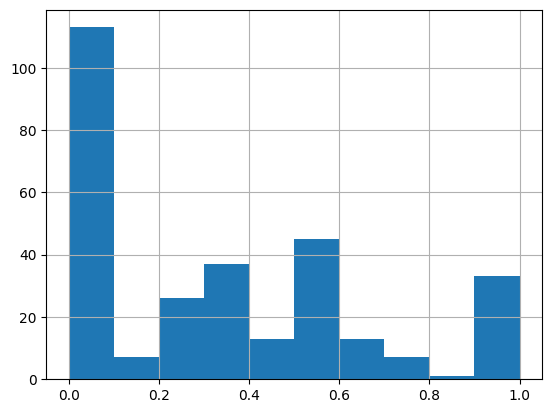

In [20]:
df.recall.hist()

<AxesSubplot:>

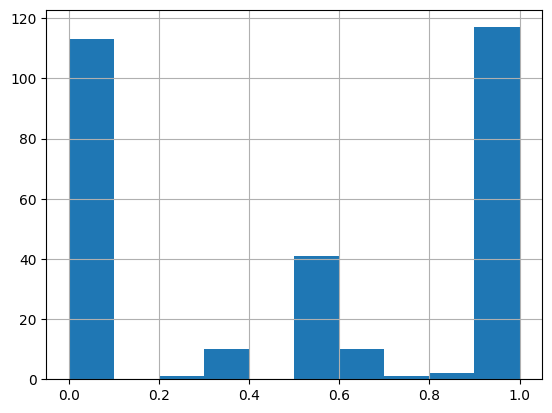

In [21]:
df.precision.hist()

In [22]:
from collections import Counter

rel_counter = Counter()
entity_counter = Counter()
with open("logs_second_prompt_with_text_and_triplets100.jsonl", 'r') as f:
    for line in f:
        line = json.loads(line)
        pr = line[-1]["aligned_precision"]
        pr = float(pr)

        if pr == 0:
            for triplet in line[-1]["target"]['text_triplets']:
             rel_counter[triplet[1]] += 1
             entity_counter[triplet[0]] += 1
             entity_counter[triplet[2]] += 1


with open("logs_second_prompt_with_text_and_triplets150.jsonl", 'r') as f:
    for line in f:
        line = json.loads(line)
        pr = line[-1]["aligned_precision"]
        pr = float(pr)

        if pr == 0:
            for triplet in line[-1]["target"]['text_triplets']:
             rel_counter[triplet[1]] += 1
             entity_counter[triplet[0]] += 1
             entity_counter[triplet[2]] += 1

In [23]:
rel_counter.most_common(20)

[('instance_of', 32),
 ('country', 21),
 ('located_in_the_administrative_territorial_entity', 19),
 ('subclass_of', 6),
 ('record_label', 6),
 ('shares_border_with', 6),
 ('product_or_material_produced', 6),
 ('facet_of', 5),
 ('sport', 5),
 ('sports_season_of_league_or_competition', 5),
 ('country_of_origin', 5),
 ('performer', 5),
 ('languages_spoken,_written_or_signed', 4),
 ('winner', 4),
 ('located_in_time_zone', 4),
 ('country_for_sport', 4),
 ('for_work', 4),
 ('legal_form', 3),
 ('language_of_work_or_name', 3),
 ('named_after', 3)]

In [25]:
entity_counter.most_common(10)

[('Deira, Dubai', 10),
 ('United States', 7),
 ('Bugahyeon-dong', 6),
 ('Artigas Mausoleum', 6),
 ('Marathon Sports', 6),
 ('Student Union at the Royal Institute of Technology', 6),
 ('2010–11 Belarusian Extraliga season', 6),
 ('Isola Sacra Necropolis', 6),
 ('Bohuslávky', 6),
 ('Confessor', 5)]

In [29]:
aligner = Aligner(device='cuda:2')
extractor = LLMTripletExtractor()
triplet_filter = TripletFilter()

In [35]:
aligner.top_similar_entities("is", 50)

{'names': ['Is Is',
  '.is',
  'Isri',
  'Isera',
  'Isep',
  'Isias',
  'Isba',
  'Where It Is',
  'Isetta',
  'ISCU',
  'ISEPIC',
  'The Ancestor',
  'Åre',
  'Seeks',
  'Isin',
  'Isín',
  'UNESCO',
  'Andlu',
  'Is the Is Are',
  'Isco',
  'She Is',
  'This Is a Low',
  'Arewa',
  'Arega',
  'Islord',
  'Israna',
  'Ishar',
  'İşbank',
  'Ise Line',
  'Ishi',
  'Õle',
  'The Only High',
  'He Is',
  'Gram',
  'Andua',
  'Isham',
  'Iserlia',
  'Mark Page',
  'AirPort',
  'Airport',
  'Areola',
  'Resonance',
  'ISG15',
  'ISDB',
  'Prized',
  'AREP',
  'Isert',
  'Acronym',
  'Helix',
  'Areines'],
 'ids': ['Q3311861',
  'Q39896',
  'Q1753629',
  'Q290754',
  'Q748284',
  'Q2495012',
  'Q1520533',
  'Q4019444',
  'Q720835',
  'Q21105385',
  'Q5973837',
  'Q3818640',
  'Q271138',
  'Q3477678',
  'Q501259',
  'Q735574',
  'Q7809',
  'Q4754511',
  'Q21450463',
  'Q80892',
  'Q24273150',
  'Q7786016',
  'Q4789122',
  'Q640900',
  'Q5824718',
  'Q30693723',
  'Q635004',
  'Q909613',
  '

In [4]:
dataset_name = 'synthie_text' # 'synthie_code', 'rebel', 'synthie_text_pc', 'synthie_code_pc', 'rebel_pc'
split = "test_small" # "train", "test", "test_small"

dataset = datasets.load_dataset(f"martinjosifoski/SynthIE", dataset_name, split=split)

In [5]:
dataset[0]

{'id': 856,
 'text': 'Harold Schwartz is a human who is a citizen of the United States.',
 'triplets': [{'subject': "{'surfaceform': 'Harold_Schwartz', 'uri': 'Q65568450'}",
   'predicate': "{'surfaceform': 'country of citizenship', 'uri': 'P27'}",
   'object': "{'surfaceform': 'United_States', 'uri': 'Q30'}"},
  {'subject': "{'surfaceform': 'Harold_Schwartz', 'uri': 'Q65568450'}",
   'predicate': "{'surfaceform': 'instance of', 'uri': 'P31'}",
   'object': "{'surfaceform': 'Human', 'uri': 'Q5'}"}],
 'entities': [{'surfaceform': 'Harold_Schwartz', 'uri': 'Q65568450'},
  {'surfaceform': 'United_States', 'uri': 'Q30'},
  {'surfaceform': 'Human', 'uri': 'Q5'}],
 'relations': [{'surfaceform': 'country of citizenship', 'uri': 'P27'},
  {'surfaceform': 'instance of', 'uri': 'P31'}]}

In [27]:
from tqdm import tqdm

entities = set()
relations = set()

for item in tqdm(dataset):

    for triplet in item['triplets']:
        entities.add(eval(triplet['subject'])['uri'])
        entities.add(eval(triplet['object'])['uri'])
        relations.add(eval(triplet['predicate'])['uri'])

100%|██████████| 10000/10000 [00:02<00:00, 3505.54it/s]


In [28]:
assert len(set(entities) - set(aligner.id2entity.keys())) == 0

In [29]:
assert len(set(relations) - set(aligner.id2relation.keys())) == 0

In [30]:
def transform_targets_syntie(sample):
    targets = {"text_triplets": [], "triplets": []}
    for t in sample:
        rel = eval(t['predicate'])
        # rel_label =  "_".join(rel['surfaceform'].split())
        rel_label =  "_".join(rel['surfaceform'].split())
        rel_id = rel['uri']
        
        head = eval(t['subject'])
        head_label = " ".join(head['surfaceform'].split("_"))
        head_id = head['uri']

        tail =  eval(t['object'])
        tail_label = " ".join(tail['surfaceform'].split("_"))
        tail_id = tail['uri']

        targets['text_triplets'].append((head_label, rel_label, tail_label))
        targets['triplets'].append((head_id, rel_id, tail_id))

    return targets

In [31]:
# ## for generated triplets
# def transform_triplets_synthie(triplets, aligner):

#     triplet2triplets = {}
#     for triplet in triplets:
#         print("TRIPLET: ", triplet['subject'], triplet['relation'], triplet['object'], "\nCONSTRUCTED TRIPLETS: ")
#         similar_relations = aligner.top_similar_relations(triplet['relation'])["ids"]
#         similar_subjects = aligner.top_similar_entities(triplet['subject'])["ids"]
#         similar_objects = aligner.top_similar_entities(triplet['object'])["ids"]

#         resulted_valid_triplets = triplet_filter.triplet_constructor(similar_relations, similar_subjects, similar_objects)
#         triplet = (triplet['subject'], triplet['relation'], triplet['object'])
        
#         if len(resulted_valid_triplets) > 0:
#             triplet2triplets[triplet] = []

#             for valid_triplet in resulted_valid_triplets:
#                 head = aligner.id2entity[valid_triplet[0]]
#                 relation = aligner.id2relation[valid_triplet[1]]
#                 tail = aligner.id2entity[valid_triplet[2]]

#                 triplet2triplets[triplet].append((head, relation, tail))

#                 print(head, relation, tail)
#         print()
        


In [32]:
# extract triplets in the format to calculate metrics properly, no entity aligning
def transform_results(results):
    transformed_results = []
    results = json.loads(results)

    for res in results:
        rel = res['relation']
        rel = " ".join(rel.split("_"))
        head, tail = res['subject'], res['object']
        transformed_results.append((head, rel, tail))
    
    return transformed_results

In [33]:
def align_results(results, aligner):
    transformed_result_ids = []
    transformed_results = []
    filtered_triplets = []
    results = json.loads(results)

    print("UNPROCESSED RESULTS", "\n", results)
    

    for res in results:
        rel = res['relation']
        rel = " ".join(rel.split("_"))
        head, tail = res['subject'], res['object']

        if (rel in aligner.relation2id) and (head in aligner.entity2id) and (tail in aligner.entity2id):
            rel_id = aligner.relation2id[rel]
            head_id = aligner.entity2id[head]
            tail_id = aligner.entity2id[tail]

            if triplet_filter.check_triplet_validity(head_id, rel_id, tail_id):
        
                transformed_result_ids.append((head_id, rel_id, tail_id))
                transformed_results.append((head, rel, tail))

            elif triplet_filter.check_triplet_validity(tail_id, rel_id, head_id):
                transformed_result_ids.append((tail_id, rel_id, head_id))
                transformed_results.append((tail_id, rel_id, head_id))
            
            else:
                filtered_triplets.append((head, rel, tail))
                
        else:
            filtered_triplets.append((head, rel, tail))
            # similar_rel = aligner.top_similar_relations(rel, k=1)[0]
            # rel = similar_rel
            # rel_id = aligner.relation2id[similar_rel]

            # similar_head = aligner.top_similar_entities(head, k=1)[0]
            # head = similar_head
            # head_id = aligner.entity2id[similar_head]

            # similar_tail = aligner.top_similar_entities(tail, k=1)[0]
            # tail = similar_tail
            # tail_id = aligner.entity2id[similar_tail]

    print("PROCESSED RESULT: ", transformed_results)
    print("FILTERED TRIPLETS: ", filtered_triplets)
        
    return transformed_result_ids

In [34]:
random_items = np.random.choice(list(range(0, len(dataset))), size=50, replace=False, )
random_items

array([9376, 5439,  127, 2766, 8962, 8989, 6575, 8577, 1802,  389, 2971,
       4731, 7418, 9210, 7157, 3708, 5584, 8479, 7609, 4017, 1149, 9792,
       3425, 5458, 2568, 7148, 1213, 2608, 6290, 3847, 2311, 2276,  399,
       8486, 6374, 6968, 2966,  373, 5114, 4274, 5563, 9549, 8407, 1735,
       4983, 2469, 4286, 4104, 8524, 5186])

In [12]:
logs = []

unaligned_results = []
result_ids = []

targets = []
target_ids = []


for i in range(0, 10):

    i = int(i)
    text = dataset[i]['text']
    print("TEXT: " + text)

    target = transform_targets_syntie(dataset['triplets'][i])

    triplets = extractor.get_completion_first_query(text)

    triplets = triplets.strip()

    result_unaligned = transform_results(triplets)
    

    similar_relations = aligner.top_relations_by_llm_output(llm_output=triplets)
    similar_entities = aligner.top_entities_by_llm_output(llm_output=triplets, entity_type='subject')
    similar_entities.extend(aligner.top_entities_by_llm_output(llm_output=triplets, entity_type='object'))

    similar_relations = "\n".join([re.sub("[\[\]\{\}\']", '', str(item)) for item in similar_relations])
    similar_entities = "\n".join([re.sub("[\[\]\{\}\']", '', str(item)) for item in similar_entities])
    
    res = extractor.get_completion_second_query(similar_entities=similar_entities, similar_relations=similar_relations)
    res_ids = align_results(res, aligner)

    print('TARGETS: ' + str(target['text_triplets']), end='\n\n')

    targets.append(target['text_triplets'])
    target_ids.append(target['triplets'])

    result_ids.append(res_ids)
    unaligned_results.append(result_unaligned)

    logs.append(extractor.messages.copy())
    
    time.sleep(0.5)

TEXT: Harold Schwartz is a human who is a citizen of the United States.


DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'role': 'system', 'content': 'You are an algorithm designed for extracting facts from text in a structured format to build a knowledge graph. Knowledge graph consists of set of triplets. Each triplet contains two entities (subject and object) and one relation that connects these subject and object. Entities represent nodes in knowledge graph, while relation represents a link between these two nodes. \nSubjects and objects could be named entities or concepts describing a group of people, event or abstract object from Wikidata knowledge graph. \nYou will be provided with the text entitled as "Text:". You are expected to output only the list of identified triplets in a json format as a list of triplets. Each triplet should have fields "subject", "relation", and "object" for subject, relation, and object correspondingly. \n\n<example>\nInput:\nText: Albert Ei

Mapping of top-5 similar relations from Wikidata:
nationality: country of citizenship, country of origin, native language, date of birth, place of birth
instance_of: is metaclass for, has index case, index case of, instance of, has grammatical case

Mapping of top-5 similar entities from Wikidata:
Harold Schwartz: Harold Schwartz, Morris Schwartz, Jerome Schwartz, Paul Schwartz, Irving Schwartz
Harold Schwartz: Harold Schwartz, Morris Schwartz, Jerome Schwartz, Paul Schwartz, Irving Schwartz
United States: United States, United Residents, The United, United Kingdom, United Republic
human: Human, Humanos, Human Is, Human Entertainment, Humanin


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Thu, 18 Apr 2024 16:24:45 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'Keep-Alive', b'timeout=20'), (b'access-control-allow-origin', b'*'), (b'Cache-Control', b'no-cache, must-revalidate'), (b'openai-model', b'gpt-3.5-turbo-0125'), (b'openai-organization', b'user-lafzdq3zadvnkudihgsmrbg5'), (b'openai-processing-ms', b'2310'), (b'openai-version', b'2020-10-01'), (b'strict-transport-security', b'max-age=15724800; includeSubDomains'), (b'x-ratelimit-limit-requests', b'10000'), (b'x-ratelimit-limit-tokens', b'2000000'), (b'x-ratelimit-remaining-requests', b'9999'), (b'x-ratelimit-remaining-tokens', b'1998937'), (b'x-ratelimit-reset-requests', b'6ms'), (b'x-ratelimit-reset-tokens', b'31ms'), (b'x-request-id', b'req_d912e0805f4360689ccb6e47929ad4d9'), (b'CF-Cache-Status', b'DYNAMIC'), (b'Set

UNPROCESSED RESULTS 
 [{'subject': 'Harold Schwartz', 'relation': 'country of citizenship', 'object': 'United States'}, {'subject': 'Harold Schwartz', 'relation': 'instance of', 'object': 'Human'}]
PROCESSED RESULT:  [('Harold Schwartz', 'country of citizenship', 'United States'), ('Harold Schwartz', 'instance of', 'Human')]
FILTERED TRIPLETS:  []
TARGETS: [('Harold Schwartz', 'country_of_citizenship', 'United States'), ('Harold Schwartz', 'instance_of', 'Human')]

TEXT: Nate Blackwell was born in Philadelphia, Pennsylvania. He is a professional basketball player in the National Basketball Association and was educated at Temple University. His native language is English. Philadelphia County, Pennsylvania is coextensive with Philadelphia and shares a border with Lower Moreland Township, Montgomery County, Pennsylvania.


DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'role': 'system', 'content': 'You are an algorithm designed for extracting facts from text in a structured format to build a knowledge graph. Knowledge graph consists of set of triplets. Each triplet contains two entities (subject and object) and one relation that connects these subject and object. Entities represent nodes in knowledge graph, while relation represents a link between these two nodes. \nSubjects and objects could be named entities or concepts describing a group of people, event or abstract object from Wikidata knowledge graph. \nYou will be provided with the text entitled as "Text:". You are expected to output only the list of identified triplets in a json format as a list of triplets. Each triplet should have fields "subject", "relation", and "object" for subject, relation, and object correspondingly. \n\n<example>\nInput:\nText: Albert Ei

Mapping of top-5 similar relations from Wikidata:
place_of_birth: place of birth, place of death, date of birth, place of burial, date of baptism in early childhood
occupation: occupation, field of this occupation, enclave within, territory claimed by, residence
organization: office held by head of the organization, parent organization, student organization of, organization directed by the office or position, organizer
education: educational stage, student, academic degree, grants, school of
native_language: native language, name in native language, language regulatory body, original language of film or TV show, official language
coextensive_with: coextensive with, linguistic typology, generalization of, partially coincident with, grammatical option indicates
shares_border_with: shares border with, territory overlaps, has boundary, graph radius, central bank/issuer

Mapping of top-5 similar entities from Wikidata:
Nate Blackwell: Nate Blackwell, Cory Blackwell, Nick Blackwell, Luke Bla

DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Thu, 18 Apr 2024 16:25:04 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'Keep-Alive', b'timeout=20'), (b'access-control-allow-origin', b'*'), (b'Cache-Control', b'no-cache, must-revalidate'), (b'openai-model', b'gpt-3.5-turbo-0125'), (b'openai-organization', b'user-lafzdq3zadvnkudihgsmrbg5'), (b'openai-processing-ms', b'5176'), (b'openai-version', b'2020-10-01'), (b'strict-transport-security', b'max-age=15724800; includeSubDomains'), (b'x-ratelimit-limit-requests', b'10000'), (b'x-ratelimit-limit-tokens', b'2000000'), (b'x-ratelimit-remaining-requests', b'9999'), (b'x-ratelimit-remaining-tokens', b'1998104'), (b'x-ratelimit-reset-requests', b'6ms'), (b'x-ratelimit-reset-tokens', b'56ms'), (b'x-request-id', b'req_d9bb38664dd5ab33a199cc5f924820a4'), (b'CF-Cache-Status', b'DYNAMIC'), (b'Set

UNPROCESSED RESULTS 
 [{'subject': 'Nate Blackwell', 'relation': 'place of birth', 'object': 'Philadelphia, Pennsylvania'}, {'subject': 'Nate Blackwell', 'relation': 'occupation', 'object': 'professional basketball player'}, {'subject': 'Nate Blackwell', 'relation': 'organization', 'object': 'National Basketball Association'}, {'subject': 'Nate Blackwell', 'relation': 'education', 'object': 'Temple University'}, {'subject': 'Nate Blackwell', 'relation': 'native language', 'object': 'English'}, {'subject': 'Philadelphia County, Pennsylvania', 'relation': 'coextensive with', 'object': 'Philadelphia'}, {'subject': 'Philadelphia County, Pennsylvania', 'relation': 'shares border with', 'object': 'Lower Moreland Township, Montgomery County, Pennsylvania'}]
PROCESSED RESULT:  [('Philadelphia County, Pennsylvania', 'coextensive with', 'Philadelphia'), ('Philadelphia County, Pennsylvania', 'shares border with', 'Lower Moreland Township, Montgomery County, Pennsylvania')]
FILTERED TRIPLETS:  [('

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'role': 'system', 'content': 'You are an algorithm designed for extracting facts from text in a structured format to build a knowledge graph. Knowledge graph consists of set of triplets. Each triplet contains two entities (subject and object) and one relation that connects these subject and object. Entities represent nodes in knowledge graph, while relation represents a link between these two nodes. \nSubjects and objects could be named entities or concepts describing a group of people, event or abstract object from Wikidata knowledge graph. \nYou will be provided with the text entitled as "Text:". You are expected to output only the list of identified triplets in a json format as a list of triplets. Each triplet should have fields "subject", "relation", and "object" for subject, relation, and object correspondingly. \n\n<example>\nInput:\nText: Albert Ei

Mapping of top-5 similar relations from Wikidata:
place_of_birth: place of birth, place of death, date of birth, place of burial, date of baptism in early childhood
served_in: service entry, service retirement, repealed by, serving temperature, OCLC number
rank: military rank, next higher rank, next lower rank, ranking, captain
rank: military rank, next higher rank, next lower rank, ranking, captain
fought_in: conflict, order of battle, number of casualties, colonel-in-chief, military casualty classification
fought_in: conflict, order of battle, number of casualties, colonel-in-chief, military casualty classification
fought_in: conflict, order of battle, number of casualties, colonel-in-chief, military casualty classification
contributed_to: signatory, contributed to creative work, reply to, contributor to the creative work or subject, dedicated to
contributed_to: signatory, contributed to creative work, reply to, contributor to the creative work or subject, dedicated to

Mapping of to

DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Thu, 18 Apr 2024 16:25:41 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'Keep-Alive', b'timeout=20'), (b'access-control-allow-origin', b'*'), (b'Cache-Control', b'no-cache, must-revalidate'), (b'openai-model', b'gpt-3.5-turbo-0125'), (b'openai-organization', b'user-lafzdq3zadvnkudihgsmrbg5'), (b'openai-processing-ms', b'7405'), (b'openai-version', b'2020-10-01'), (b'strict-transport-security', b'max-age=15724800; includeSubDomains'), (b'x-ratelimit-limit-requests', b'10000'), (b'x-ratelimit-limit-tokens', b'2000000'), (b'x-ratelimit-remaining-requests', b'9999'), (b'x-ratelimit-remaining-tokens', b'1997912'), (b'x-ratelimit-reset-requests', b'6ms'), (b'x-ratelimit-reset-tokens', b'62ms'), (b'x-request-id', b'req_9e955df8304d99f57eb3961761bed051'), (b'CF-Cache-Status', b'DYNAMIC'), (b'Set

UNPROCESSED RESULTS 
 [{'subject': 'Nathan George Evans', 'relation': 'place of birth', 'object': 'Marion, South Carolina'}, {'subject': 'Nathan George Evans', 'relation': 'served_in', 'object': 'Confederate States of America'}, {'subject': 'Nathan George Evans', 'relation': 'military rank', 'object': 'Brigadier general'}, {'subject': 'Nathan George Evans', 'relation': 'fought_in', 'object': 'Battle of Antietam'}, {'subject': 'Nathan George Evans', 'relation': 'fought_in', 'object': 'Battle of Balls Bluff'}, {'subject': 'Nathan George Evans', 'relation': 'fought_in', 'object': 'Second Battle of Bull Run'}, {'subject': 'Kansas–Nebraska Act', 'relation': 'contributed to', 'object': 'American Civil War'}, {'subject': 'John Browns raid on Harpers Ferry', 'relation': 'contributed to', 'object': 'American Civil War'}]
PROCESSED RESULT:  [('Nathan George Evans', 'place of birth', 'Marion, South Carolina'), ('Nathan George Evans', 'military rank', 'Brigadier general')]
FILTERED TRIPLETS:  [('N

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'role': 'system', 'content': 'You are an algorithm designed for extracting facts from text in a structured format to build a knowledge graph. Knowledge graph consists of set of triplets. Each triplet contains two entities (subject and object) and one relation that connects these subject and object. Entities represent nodes in knowledge graph, while relation represents a link between these two nodes. \nSubjects and objects could be named entities or concepts describing a group of people, event or abstract object from Wikidata knowledge graph. \nYou will be provided with the text entitled as "Text:". You are expected to output only the list of identified triplets in a json format as a list of triplets. Each triplet should have fields "subject", "relation", and "object" for subject, relation, and object correspondingly. \n\n<example>\nInput:\nText: Albert Ei

Mapping of top-5 similar relations from Wikidata:
set_in: input set, instruction set, set in environment, group cardinality, is metaclass for
features: introduced feature, located on terrain feature, supports programming language, replaces, socket supported

Mapping of top-5 similar entities from Wikidata:
Family Matters: Family Matters, Family Affairs, List of Family Matters characters, Family Relations, Food Matters
Family Matters: Family Matters, Family Affairs, List of Family Matters characters, Family Relations, Food Matters
1989: 1989, 1990, 1988, 1987, 1991
List of Family Matters characters: List of Family Matters characters, List of Family Affairs characters, List of Modern Family characters, Family Matters, Family Values (comics)


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Thu, 18 Apr 2024 16:25:50 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'Keep-Alive', b'timeout=20'), (b'access-control-allow-origin', b'*'), (b'Cache-Control', b'no-cache, must-revalidate'), (b'openai-model', b'gpt-3.5-turbo-0125'), (b'openai-organization', b'user-lafzdq3zadvnkudihgsmrbg5'), (b'openai-processing-ms', b'1875'), (b'openai-version', b'2020-10-01'), (b'strict-transport-security', b'max-age=15724800; includeSubDomains'), (b'x-ratelimit-limit-requests', b'10000'), (b'x-ratelimit-limit-tokens', b'2000000'), (b'x-ratelimit-remaining-requests', b'9999'), (b'x-ratelimit-remaining-tokens', b'1998896'), (b'x-ratelimit-reset-requests', b'6ms'), (b'x-ratelimit-reset-tokens', b'33ms'), (b'x-request-id', b'req_6250c182984b4518abf074001f5c8241'), (b'CF-Cache-Status', b'DYNAMIC'), (b'Set

UNPROCESSED RESULTS 
 [{'subject': 'Family Matters', 'relation': 'input set', 'object': '1989'}, {'subject': 'Family Matters', 'relation': 'introduced feature', 'object': 'List of Family Matters characters'}]
PROCESSED RESULT:  []
FILTERED TRIPLETS:  [('Family Matters', 'input set', '1989'), ('Family Matters', 'introduced feature', 'List of Family Matters characters')]
TARGETS: [('Family Matters', 'set_in_period', '1989'), ('Family Matters', 'list_of_characters', 'List of Family Matters characters')]

TEXT: Harry Agar Lyons was an actor.


DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'role': 'system', 'content': 'You are an algorithm designed for extracting facts from text in a structured format to build a knowledge graph. Knowledge graph consists of set of triplets. Each triplet contains two entities (subject and object) and one relation that connects these subject and object. Entities represent nodes in knowledge graph, while relation represents a link between these two nodes. \nSubjects and objects could be named entities or concepts describing a group of people, event or abstract object from Wikidata knowledge graph. \nYou will be provided with the text entitled as "Text:". You are expected to output only the list of identified triplets in a json format as a list of triplets. Each triplet should have fields "subject", "relation", and "object" for subject, relation, and object correspondingly. \n\n<example>\nInput:\nText: Albert Ei

Mapping of top-5 similar relations from Wikidata:
occupation: occupation, field of this occupation, enclave within, territory claimed by, residence

Mapping of top-5 similar entities from Wikidata:
Harry Agar Lyons: Harry Agar Lyons, Cyril Lyons, Lewis Lyons, Edward Lyons, John Agar
actor: Actor, Character actor, Hari (actor), Bach (actor), Leading actor


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Thu, 18 Apr 2024 16:25:58 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'Keep-Alive', b'timeout=20'), (b'access-control-allow-origin', b'*'), (b'Cache-Control', b'no-cache, must-revalidate'), (b'openai-model', b'gpt-3.5-turbo-0125'), (b'openai-organization', b'user-lafzdq3zadvnkudihgsmrbg5'), (b'openai-processing-ms', b'806'), (b'openai-version', b'2020-10-01'), (b'strict-transport-security', b'max-age=15724800; includeSubDomains'), (b'x-ratelimit-limit-requests', b'10000'), (b'x-ratelimit-limit-tokens', b'2000000'), (b'x-ratelimit-remaining-requests', b'9999'), (b'x-ratelimit-remaining-tokens', b'1999050'), (b'x-ratelimit-reset-requests', b'6ms'), (b'x-ratelimit-reset-tokens', b'28ms'), (b'x-request-id', b'req_e0cb480573bd74ae58ab84f08ba5bf80'), (b'CF-Cache-Status', b'DYNAMIC'), (b'Set-

UNPROCESSED RESULTS 
 [{'subject': 'Harry Agar Lyons', 'relation': 'occupation', 'object': 'Actor'}]
PROCESSED RESULT:  [('Harry Agar Lyons', 'occupation', 'Actor')]
FILTERED TRIPLETS:  []
TARGETS: [('Harry Agar Lyons', 'occupation', 'Actor')]

TEXT: Swissair was an airline based in Switzerland with its headquarters in Zürich. It was the hub for Zurich Airport, and had a subsidiary called Crossair. In 2002, it was replaced by Swiss International Air Lines.


DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'role': 'system', 'content': 'You are an algorithm designed for extracting facts from text in a structured format to build a knowledge graph. Knowledge graph consists of set of triplets. Each triplet contains two entities (subject and object) and one relation that connects these subject and object. Entities represent nodes in knowledge graph, while relation represents a link between these two nodes. \nSubjects and objects could be named entities or concepts describing a group of people, event or abstract object from Wikidata knowledge graph. \nYou will be provided with the text entitled as "Text:". You are expected to output only the list of identified triplets in a json format as a list of triplets. Each triplet should have fields "subject", "relation", and "object" for subject, relation, and object correspondingly. \n\n<example>\nInput:\nText: Albert Ei

Mapping of top-5 similar relations from Wikidata:
country: country, country for sport, basin country, country of citizenship, head of state
headquarters: headquarters location, capital, official residence, location, office held by head of the organization
hub: airline hub, place served by transport hub, primary destinations, capital, base
subsidary: radix, source of income, subclass of, legislated by, linguistic typology
replaced_by: replaced by, proved by, solved by, structure replaced by, studied by

Mapping of top-5 similar entities from Wikidata:
Swissair: Swissair, Swiss World Airways, Swiss International Air Lines, Swiss Global Air Lines, ASL Airlines Switzerland
Swissair: Swissair, Swiss World Airways, Swiss International Air Lines, Swiss Global Air Lines, ASL Airlines Switzerland
Swissair: Swissair, Swiss World Airways, Swiss International Air Lines, Swiss Global Air Lines, ASL Airlines Switzerland
Swissair: Swissair, Swiss World Airways, Swiss International Air Lines, Swiss Gl

DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Thu, 18 Apr 2024 16:26:14 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'Keep-Alive', b'timeout=20'), (b'access-control-allow-origin', b'*'), (b'Cache-Control', b'no-cache, must-revalidate'), (b'openai-model', b'gpt-3.5-turbo-0125'), (b'openai-organization', b'user-lafzdq3zadvnkudihgsmrbg5'), (b'openai-processing-ms', b'5178'), (b'openai-version', b'2020-10-01'), (b'strict-transport-security', b'max-age=15724800; includeSubDomains'), (b'x-ratelimit-limit-requests', b'10000'), (b'x-ratelimit-limit-tokens', b'2000000'), (b'x-ratelimit-remaining-requests', b'9999'), (b'x-ratelimit-remaining-tokens', b'1998569'), (b'x-ratelimit-reset-requests', b'6ms'), (b'x-ratelimit-reset-tokens', b'42ms'), (b'x-request-id', b'req_a5050220c34007e54a8fb32dd5a4a06a'), (b'CF-Cache-Status', b'DYNAMIC'), (b'Set

UNPROCESSED RESULTS 
 [{'subject': 'Swissair', 'relation': 'country', 'object': 'Switzerland'}, {'subject': 'Swissair', 'relation': 'headquarters location', 'object': 'Zürich'}, {'subject': 'Swissair', 'relation': 'airline hub', 'object': 'Zurich Airport'}, {'subject': 'Swissair', 'relation': 'subsidary', 'object': 'Crossair'}, {'subject': 'Swissair', 'relation': 'replaced by', 'object': 'Swiss International Air Lines'}]
PROCESSED RESULT:  [('Swissair', 'country', 'Switzerland'), ('Swissair', 'headquarters location', 'Zürich'), ('Swissair', 'airline hub', 'Zurich Airport'), ('Swissair', 'replaced by', 'Swiss International Air Lines')]
FILTERED TRIPLETS:  [('Swissair', 'subsidary', 'Crossair')]
TARGETS: [('Swissair', 'airline_hub', 'Zurich Airport'), ('Swissair', 'replaced_by', 'Swiss International Air Lines'), ('Swissair', 'subsidiary', 'Crossair'), ('Swissair', 'headquarters_location', 'Zürich'), ('Swissair', 'country', 'Switzerland')]

TEXT: Carlos Semprún was a prolific writer who w

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'role': 'system', 'content': 'You are an algorithm designed for extracting facts from text in a structured format to build a knowledge graph. Knowledge graph consists of set of triplets. Each triplet contains two entities (subject and object) and one relation that connects these subject and object. Entities represent nodes in knowledge graph, while relation represents a link between these two nodes. \nSubjects and objects could be named entities or concepts describing a group of people, event or abstract object from Wikidata knowledge graph. \nYou will be provided with the text entitled as "Text:". You are expected to output only the list of identified triplets in a json format as a list of triplets. Each triplet should have fields "subject", "relation", and "object" for subject, relation, and object correspondingly. \n\n<example>\nInput:\nText: Albert Ei

Mapping of top-5 similar relations from Wikidata:
language: language used, official language, native language, dialect of, language regulatory body
language: language used, official language, native language, dialect of, language regulatory body
place_of_death: place of death, place of burial, place of birth, location of creation, manner of death
has_sibling: sibling, relative, parent cell line, mode of inheritance, parent taxon

Mapping of top-5 similar entities from Wikidata:
Carlos Semprún: Carlos Semprún, Jorge Semprún, Pablo Semprún, Jaime Semprún, José Alejandro Semprún
Carlos Semprún: Carlos Semprún, Jorge Semprún, Pablo Semprún, Jaime Semprún, José Alejandro Semprún
Carlos Semprún: Carlos Semprún, Jorge Semprún, Pablo Semprún, Jaime Semprún, José Alejandro Semprún
Carlos Semprún: Carlos Semprún, Jorge Semprún, Pablo Semprún, Jaime Semprún, José Alejandro Semprún
French: French California, French Laurence, Frenchie, France, French polish
Spanish: Old Spanish, Spanish real, Mexic

DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Thu, 18 Apr 2024 16:26:27 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'Keep-Alive', b'timeout=20'), (b'access-control-allow-origin', b'*'), (b'Cache-Control', b'no-cache, must-revalidate'), (b'openai-model', b'gpt-3.5-turbo-0125'), (b'openai-organization', b'user-lafzdq3zadvnkudihgsmrbg5'), (b'openai-processing-ms', b'2959'), (b'openai-version', b'2020-10-01'), (b'strict-transport-security', b'max-age=15724800; includeSubDomains'), (b'x-ratelimit-limit-requests', b'10000'), (b'x-ratelimit-limit-tokens', b'2000000'), (b'x-ratelimit-remaining-requests', b'9999'), (b'x-ratelimit-remaining-tokens', b'1998711'), (b'x-ratelimit-reset-requests', b'6ms'), (b'x-ratelimit-reset-tokens', b'38ms'), (b'x-request-id', b'req_04001a8fb36d5543c6e2a3adbb76a7dd'), (b'CF-Cache-Status', b'DYNAMIC'), (b'Set

UNPROCESSED RESULTS 
 [{'subject': 'Carlos Semprún', 'relation': 'language used', 'object': 'French'}, {'subject': 'Carlos Semprún', 'relation': 'language used', 'object': 'Spanish'}, {'subject': 'Carlos Semprún', 'relation': 'place of death', 'object': 'Paris'}, {'subject': 'Carlos Semprún', 'relation': 'sibling', 'object': 'Jorge Semprún'}]
PROCESSED RESULT:  [('Carlos Semprún', 'place of death', 'Paris'), ('Carlos Semprún', 'sibling', 'Jorge Semprún')]
FILTERED TRIPLETS:  [('Carlos Semprún', 'language used', 'French'), ('Carlos Semprún', 'language used', 'Spanish')]
TARGETS: [('Carlos Semprún', 'writing_language', 'French language'), ('Carlos Semprún', 'writing_language', 'Spanish language'), ('Carlos Semprún', 'place_of_death', 'Paris'), ('Carlos Semprún', 'sibling', 'Jorge Semprún')]

TEXT: The Alliance Theatre is a theatre located in the U.S. state of Georgia and is a subsidiary of the Woodruff Arts Center. It has received the Regional Theatre Tony Award and is part of the United

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'role': 'system', 'content': 'You are an algorithm designed for extracting facts from text in a structured format to build a knowledge graph. Knowledge graph consists of set of triplets. Each triplet contains two entities (subject and object) and one relation that connects these subject and object. Entities represent nodes in knowledge graph, while relation represents a link between these two nodes. \nSubjects and objects could be named entities or concepts describing a group of people, event or abstract object from Wikidata knowledge graph. \nYou will be provided with the text entitled as "Text:". You are expected to output only the list of identified triplets in a json format as a list of triplets. Each triplet should have fields "subject", "relation", and "object" for subject, relation, and object correspondingly. \n\n<example>\nInput:\nText: Albert Ei

Mapping of top-5 similar relations from Wikidata:
location: location, work location, coordinate location, headquarters location, terminus location
awards_received: award received, nominated by, member category, conferred by, related category
part_of: part of, has part, applies to part, does not have part, part of the series
part_of: part of, has part, applies to part, does not have part, part of the series

Mapping of top-5 similar entities from Wikidata:
Alliance Theatre: Alliance Theatre, Alliance Films, Alliance University, The Alliance School, Alliance Center
Alliance Theatre: Alliance Theatre, Alliance Films, Alliance University, The Alliance School, Alliance Center
Alliance Theatre: Alliance Theatre, Alliance Films, Alliance University, The Alliance School, Alliance Center
Alliance Theatre: Alliance Theatre, Alliance Films, Alliance University, The Alliance School, Alliance Center
Georgia: Georgia Hard, 112 Georgia, Sky Georgia, Georgia Rose, Georgia, Georgia
Regional Theatre Ton

DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Thu, 18 Apr 2024 16:26:41 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'Keep-Alive', b'timeout=20'), (b'access-control-allow-origin', b'*'), (b'Cache-Control', b'no-cache, must-revalidate'), (b'openai-model', b'gpt-3.5-turbo-0125'), (b'openai-organization', b'user-lafzdq3zadvnkudihgsmrbg5'), (b'openai-processing-ms', b'2971'), (b'openai-version', b'2020-10-01'), (b'strict-transport-security', b'max-age=15724800; includeSubDomains'), (b'x-ratelimit-limit-requests', b'10000'), (b'x-ratelimit-limit-tokens', b'2000000'), (b'x-ratelimit-remaining-requests', b'9999'), (b'x-ratelimit-remaining-tokens', b'1998668'), (b'x-ratelimit-reset-requests', b'6ms'), (b'x-ratelimit-reset-tokens', b'39ms'), (b'x-request-id', b'req_601b80aad4faed10c9c6f935d9c1cee5'), (b'CF-Cache-Status', b'DYNAMIC'), (b'Set

UNPROCESSED RESULTS 
 [{'subject': 'Alliance Theatre', 'relation': 'location', 'object': 'Georgia'}, {'subject': 'Alliance Theatre', 'relation': 'award received', 'object': 'Regional Theatre Tony Award'}, {'subject': 'Alliance Theatre', 'relation': 'part of', 'object': 'Woodruff Arts Center'}, {'subject': 'Alliance Theatre', 'relation': 'part of', 'object': 'United States'}]
PROCESSED RESULT:  [('Alliance Theatre', 'award received', 'Regional Theatre Tony Award'), ('Alliance Theatre', 'part of', 'Woodruff Arts Center'), ('Alliance Theatre', 'part of', 'United States')]
FILTERED TRIPLETS:  [('Alliance Theatre', 'location', 'Georgia')]
TARGETS: [('Alliance Theatre', 'parent_organization', 'Woodruff Arts Center'), ('Alliance Theatre', 'award_received', 'Regional Theatre Tony Award'), ('Alliance Theatre', 'located_in_the_administrative_territorial_entity', 'Georgia (U.S. state)'), ('Alliance Theatre', 'country', 'United States'), ('Woodruff Arts Center', 'subsidiary', 'Alliance Theatre')]


DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'role': 'system', 'content': 'You are an algorithm designed for extracting facts from text in a structured format to build a knowledge graph. Knowledge graph consists of set of triplets. Each triplet contains two entities (subject and object) and one relation that connects these subject and object. Entities represent nodes in knowledge graph, while relation represents a link between these two nodes. \nSubjects and objects could be named entities or concepts describing a group of people, event or abstract object from Wikidata knowledge graph. \nYou will be provided with the text entitled as "Text:". You are expected to output only the list of identified triplets in a json format as a list of triplets. Each triplet should have fields "subject", "relation", and "object" for subject, relation, and object correspondingly. \n\n<example>\nInput:\nText: Albert Ei

Mapping of top-5 similar relations from Wikidata:
type: voice type, has fruit type, type of orbit, type of electrification, payment types accepted
located_in: location, coordinate location, headquarters location, located in time zone, work location

Mapping of top-5 similar entities from Wikidata:
Makineh Nasiri: Makineh Nasiri, Naseh, Nasiriyah, Mehdi Nasiri, Alireza Nasiri
Makineh Nasiri: Makineh Nasiri, Naseh, Nasiriyah, Mehdi Nasiri, Alireza Nasiri
village: Village, Village District, Urban village, Voivodeship, German Village
Iran: Iran, Tehran Province, Taft, Iran, Iranian Persian, Iranistan


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Thu, 18 Apr 2024 16:26:52 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'Keep-Alive', b'timeout=20'), (b'access-control-allow-origin', b'*'), (b'Cache-Control', b'no-cache, must-revalidate'), (b'openai-model', b'gpt-3.5-turbo-0125'), (b'openai-organization', b'user-lafzdq3zadvnkudihgsmrbg5'), (b'openai-processing-ms', b'1549'), (b'openai-version', b'2020-10-01'), (b'strict-transport-security', b'max-age=15724800; includeSubDomains'), (b'x-ratelimit-limit-requests', b'10000'), (b'x-ratelimit-limit-tokens', b'2000000'), (b'x-ratelimit-remaining-requests', b'9999'), (b'x-ratelimit-remaining-tokens', b'1998961'), (b'x-ratelimit-reset-requests', b'6ms'), (b'x-ratelimit-reset-tokens', b'31ms'), (b'x-request-id', b'req_c7d8fe66e9b53231b03cbd8f77ce16d0'), (b'CF-Cache-Status', b'DYNAMIC'), (b'Set

UNPROCESSED RESULTS 
 [{'subject': 'Makineh Nasiri', 'relation': 'type', 'object': 'Village'}, {'subject': 'Makineh Nasiri', 'relation': 'located_in', 'object': 'Iran'}]
PROCESSED RESULT:  []
FILTERED TRIPLETS:  [('Makineh Nasiri', 'type', 'Village'), ('Makineh Nasiri', 'located in', 'Iran')]
TARGETS: [('Makineh Nasiri', 'instance_of', 'Village'), ('Makineh Nasiri', 'country', 'Iran')]

TEXT: Csaba Szentpétery, born in Budapest, Hungary, competed in Ice dance and Figure skating as a professional athlete. He had a business and sport partnership with Regina Woodward. Ice dance is distinct from Figure skating.


DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'role': 'system', 'content': 'You are an algorithm designed for extracting facts from text in a structured format to build a knowledge graph. Knowledge graph consists of set of triplets. Each triplet contains two entities (subject and object) and one relation that connects these subject and object. Entities represent nodes in knowledge graph, while relation represents a link between these two nodes. \nSubjects and objects could be named entities or concepts describing a group of people, event or abstract object from Wikidata knowledge graph. \nYou will be provided with the text entitled as "Text:". You are expected to output only the list of identified triplets in a json format as a list of triplets. Each triplet should have fields "subject", "relation", and "object" for subject, relation, and object correspondingly. \n\n<example>\nInput:\nText: Albert Ei

Mapping of top-5 similar relations from Wikidata:
place_of_birth: place of birth, place of death, date of birth, place of burial, date of baptism in early childhood
profession: field of this occupation, industry, field of work, health specialty, service retirement
sport: sport, sport number, country for sport, sports league level, sports season of league or competition
sport: sport, sport number, country for sport, sports league level, sports season of league or competition
partnership: partnership with, together with, affiliation, airline alliance, partner in business or sport
distinct_from: separated from, different from, group cardinality, generalization of, is metaclass for

Mapping of top-5 similar entities from Wikidata:
Csaba Szentpétery: Csaba Szentpétery, Viktor Szentpéteri, Szentpéterúr, Sajószentpéter, Szentpéterfa
Csaba Szentpétery: Csaba Szentpétery, Viktor Szentpéteri, Szentpéterúr, Sajószentpéter, Szentpéterfa
Csaba Szentpétery: Csaba Szentpétery, Viktor Szentpéteri, Sze

DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Thu, 18 Apr 2024 16:27:05 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'Keep-Alive', b'timeout=20'), (b'access-control-allow-origin', b'*'), (b'Cache-Control', b'no-cache, must-revalidate'), (b'openai-model', b'gpt-3.5-turbo-0125'), (b'openai-organization', b'user-lafzdq3zadvnkudihgsmrbg5'), (b'openai-processing-ms', b'4423'), (b'openai-version', b'2020-10-01'), (b'strict-transport-security', b'max-age=15724800; includeSubDomains'), (b'x-ratelimit-limit-requests', b'10000'), (b'x-ratelimit-limit-tokens', b'2000000'), (b'x-ratelimit-remaining-requests', b'9999'), (b'x-ratelimit-remaining-tokens', b'1998444'), (b'x-ratelimit-reset-requests', b'6ms'), (b'x-ratelimit-reset-tokens', b'46ms'), (b'x-request-id', b'req_4ffcc658ae6fc5223d86d25a2227e4ec'), (b'CF-Cache-Status', b'DYNAMIC'), (b'Set

UNPROCESSED RESULTS 
 [{'subject': 'Csaba Szentpétery', 'relation': 'place of birth', 'object': 'Budapest, Hungary'}, {'subject': 'Csaba Szentpétery', 'relation': 'profession', 'object': 'professional athlete'}, {'subject': 'Csaba Szentpétery', 'relation': 'sport', 'object': 'Ice dance'}, {'subject': 'Csaba Szentpétery', 'relation': 'sport', 'object': 'Figure skating'}, {'subject': 'Csaba Szentpétery', 'relation': 'partnership with', 'object': 'Regina Woodward'}, {'subject': 'Ice dance', 'relation': 'distinct_from', 'object': 'Figure skating'}]
PROCESSED RESULT:  [('Csaba Szentpétery', 'sport', 'Ice dance'), ('Csaba Szentpétery', 'sport', 'Figure skating')]
FILTERED TRIPLETS:  [('Csaba Szentpétery', 'place of birth', 'Budapest, Hungary'), ('Csaba Szentpétery', 'profession', 'professional athlete'), ('Csaba Szentpétery', 'partnership with', 'Regina Woodward'), ('Ice dance', 'distinct from', 'Figure skating')]
TARGETS: [('Csaba Szentpétery', 'sports_discipline_competed_in', 'Ice dance'),

In [13]:
triplets

'[\n    {\n        "subject": "Csaba Szentpétery",\n        "relation": "place_of_birth",\n        "object": "Budapest, Hungary"\n    },\n    {\n        "subject": "Csaba Szentpétery",\n        "relation": "profession",\n        "object": "professional athlete"\n    },\n    {\n        "subject": "Csaba Szentpétery",\n        "relation": "sport",\n        "object": "Ice dance"\n    },\n    {\n        "subject": "Csaba Szentpétery",\n        "relation": "sport",\n        "object": "Figure skating"\n    },\n    {\n        "subject": "Csaba Szentpétery",\n        "relation": "partnership",\n        "object": "Regina Woodward"\n    },\n    {\n        "subject": "Ice dance",\n        "relation": "distinct_from",\n        "object": "Figure skating"\n    }\n]'

In [16]:
unaligned_results

[[('Harold Schwartz', 'nationality', 'United States'),
  ('Harold Schwartz', 'instance of', 'human')],
 [('Nate Blackwell', 'place of birth', 'Philadelphia, Pennsylvania'),
  ('Nate Blackwell', 'occupation', 'professional basketball player'),
  ('Nate Blackwell', 'organization', 'National Basketball Association'),
  ('Nate Blackwell', 'education', 'Temple University'),
  ('Nate Blackwell', 'native language', 'English'),
  ('Philadelphia County, Pennsylvania', 'coextensive with', 'Philadelphia'),
  ('Philadelphia County, Pennsylvania',
   'shares border with',
   'Lower Moreland Township, Montgomery County, Pennsylvania')],
 [('Nathan George Evans', 'place of birth', 'Marion, South Carolina'),
  ('Nathan George Evans', 'served in', 'Confederate States of America'),
  ('Nathan George Evans', 'rank', 'Brigadier General'),
  ('Nathan George Evans', 'rank', 'General Officer'),
  ('Nathan George Evans', 'fought in', 'Battle of Antietam'),
  ('Nathan George Evans', 'fought in', "Battle of Bal

In [17]:
target_ids

[[('Q65568450', 'P27', 'Q30'), ('Q65568450', 'P31', 'Q5')],
 [('Q4401184', 'P19', 'Q1345'),
  ('Q4401184', 'P118', 'Q155223'),
  ('Q4401184', 'P69', 'Q1420239'),
  ('Q4401184', 'P103', 'Q1860'),
  ('Q1345', 'P47', 'Q6693640'),
  ('Q1345', 'P3403', 'Q496900')],
 [('Q1966555', 'P607', 'Q8676'),
  ('Q1966555', 'P19', 'Q1424514'),
  ('Q1966555', 'P607', 'Q719252'),
  ('Q1966555', 'P607', 'Q1497909'),
  ('Q1966555', 'P607', 'Q233343'),
  ('Q1966555', 'P945', 'Q81931'),
  ('Q1966555', 'P410', 'Q152956'),
  ('Q1966555', 'P410', 'Q83460'),
  ('Q8676', 'P1479', 'Q619762'),
  ('Q8676', 'P1479', 'Q6223430')],
 [('Q593838', 'P2408', 'Q2425'), ('Q593838', 'P1881', 'Q6570699')],
 [('Q5666835', 'P106', 'Q33999')],
 [('Q694098', 'P113', 'Q15114'),
  ('Q694098', 'P1366', 'Q156776'),
  ('Q694098', 'P355', 'Q667656'),
  ('Q694098', 'P159', 'Q72'),
  ('Q694098', 'P17', 'Q39')],
 [('Q2555120', 'P6886', 'Q150'),
  ('Q2555120', 'P6886', 'Q1321'),
  ('Q2555120', 'P20', 'Q90'),
  ('Q2555120', 'P3373', 'Q157004

In [18]:
result_ids

[[('Q65568450', 'P27', 'Q30'), ('Q65568450', 'P31', 'Q5')],
 [('Q496900', 'P3403', 'Q1345'), ('Q496900', 'P47', 'Q6693640')],
 [('Q1966555', 'P19', 'Q1424514'), ('Q1966555', 'P410', 'Q152956')],
 [],
 [('Q5666835', 'P106', 'Q33999')],
 [('Q694098', 'P17', 'Q39'),
  ('Q694098', 'P159', 'Q72'),
  ('Q694098', 'P113', 'Q15114'),
  ('Q694098', 'P1366', 'Q156776')],
 [('Q2555120', 'P20', 'Q90'), ('Q2555120', 'P3373', 'Q157004')],
 [('Q4732331', 'P166', 'Q3423542'),
  ('Q4732331', 'P361', 'Q8033228'),
  ('Q4732331', 'P361', 'Q30')],
 [],
 [('Q56839660', 'P641', 'Q926191'), ('Q56839660', 'P641', 'Q38108')]]

In [20]:
targets

[[('Harold Schwartz', 'country_of_citizenship', 'United States'),
  ('Harold Schwartz', 'instance_of', 'Human')],
 [('Nate Blackwell', 'place_of_birth', 'Philadelphia'),
  ('Nate Blackwell', 'league', 'National Basketball Association'),
  ('Nate Blackwell', 'educated_at', 'Temple University'),
  ('Nate Blackwell', 'native_language', 'English language'),
  ('Philadelphia',
   'shares_border_with',
   'Lower Moreland Township, Montgomery County, Pennsylvania'),
  ('Philadelphia', 'coextensive_with', 'Philadelphia County, Pennsylvania')],
 [('Nathan George Evans', 'conflict', 'American Civil War'),
  ('Nathan George Evans', 'place_of_birth', 'Marion, South Carolina'),
  ('Nathan George Evans', 'conflict', 'Battle of Antietam'),
  ('Nathan George Evans', 'conflict', "Battle of Ball's Bluff"),
  ('Nathan George Evans', 'conflict', 'Second Battle of Bull Run'),
  ('Nathan George Evans', 'allegiance', 'Confederate States of America'),
  ('Nathan George Evans', 'military_rank', 'Brigadier gene

In [21]:
len(logs)

10

In [22]:
with open('logs.json', 'w') as f:
    json.dump(logs, f)

In [23]:
micro_recall(result_ids, target_ids), micro_precision(result_ids, target_ids)

(0.3023255813953488, 0.7222222222222222)

In [24]:
micro_recall(result_ids, target_ids), micro_precision(result_ids, target_ids)

(0.3023255813953488, 0.7222222222222222)

In [25]:
micro_recall(unaligned_results, targets), micro_precision(unaligned_results, targets)

(0.046511627906976744, 0.047619047619047616)

In [26]:
micro_recall(result_ids, target_ids), micro_precision(result_ids, target_ids)

(0.3023255813953488, 0.7222222222222222)

In [37]:
0.03 / 1000

2.9999999999999997e-05

In [38]:
0.5/1000000

5e-07

In [11]:
import json

res = []
with open('logs_100.jsonl', 'r') as f:
    i = 0
    for line in f:
        res.append(eval(line)[-1])
        i += 1


In [12]:
res = res[-100:]
len(res)

100

In [ ]:
micro_recall(result_ids, target_ids), micro_precision(result_ids, target_ids)

In [22]:
result_ids = []
target_ids = []

for r in res:
    result_ids.append([tuple(elem) for elem in r["result_aligned"]])
    target_ids.append([tuple(elem) for elem in r["target"]['triplets']] )

micro_recall(result_ids, target_ids), micro_precision(result_ids, target_ids)

(0.3057142857142857, 0.5846994535519126)

In [14]:
aligned_recall = 0
for r in res:
    aligned_recall += r["aligned_recall"]
aligned_recall/len(res)

0.30430952380952375

In [8]:
r

{'index': 19206,
 'text': 'Klwatka Szlachecka is located in Poland and its time zone is UTC+02:00 or UTC+01:00.',
 'target': {'text_triplets': [['Klwatka Szlachecka',
    'located_in_time_zone',
    'UTC+02:00'],
   ['Klwatka Szlachecka', 'located_in_time_zone', 'UTC+01:00'],
   ['Klwatka Szlachecka', 'country', 'Poland']],
  'triplets': [['Q629466', 'P421', 'Q6723'],
   ['Q629466', 'P421', 'Q6655'],
   ['Q629466', 'P17', 'Q36']]},
 'result_unaligned': [['Klwatka Szlachecka', 'located in', 'Poland'],
  ['Klwatka Szlachecka', 'time zone', 'UTC+02:00 or UTC+01:00']],
 'unaligned_precision': 0.0,
 'unaligned_recall': 0.0,
 'similar_relations': [{'located_in': ['location',
    'coordinate location',
    'headquarters location',
    'located in time zone',
    'work location']},
  {'time_zone': ['located in time zone',
    'UTC timezone offset',
    'time index',
    'start time',
    'temporal range start']}],
 'similar_entities': [{'Klwatka Szlachecka': ['Klwatka Szlachecka',
    'Wistka 

In [ ]:
[['Q629466', 'P421', 'Q6723'],
   ['Q629466', 'P421', 'Q6655'],
   ['Q629466', 'P17', 'Q36']]},